# Plots and figures for RTN-012

## Notebook boilerplate, imports, and setup

In [1]:
import logging
logging.basicConfig(format='%(asctime)s %(message)s')
logger = logging.getLogger(__name__)
logger.setLevel('DEBUG')
logger.info("Starting")

2020-11-13 17:58:22,982 Starting


In [2]:
logger.debug("Loading system modules")
import sys
import os
import random
import glob
from functools import lru_cache
from functools import partial
from configparser import ConfigParser
from copy import deepcopy

logger.debug("Loading third party modules")
import numpy as np
import pandas as pd
from numexpr import NumExpr

import matplotlib as mpl
import matplotlib.pyplot as plt

import healpy
import palpy
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
from astropy.time import Time
import astropy.units as u

logger.debug("Loading Rubin Observatory modules")
import lsst.sims.utils
from lsst.sims.seeingModel import SeeingData, SeeingModel
from lsst.sims.cloudModel import CloudData
from lsst.sims.skybrightness_pre import SkyModelPre

logger.debug("Loading zernike module")
%load_ext autoreload
%autoreload 1
%aimport lsst.sims.skybrightness_pre.zernike
%aimport zernexam

2020-11-13 17:58:23,033 Loading system modules
2020-11-13 17:58:23,043 Loading third party modules
2020-11-13 17:58:25,790 Loading Rubin Observatory modules
2020-11-13 17:58:25,911 Loading zernike module


In [3]:
SITE = EarthLocation.of_site('Cerro Pachon')
SKY_DATA_PATH = '/data/des70.a/data/neilsen/sims_skybrightness_pre/data'
NEW_MOON_MJD = 60025.2
FULL_MOON_MJD = 60010.2
BANDS = ('u', 'g', 'r', 'i', 'z', 'y')
BAND_COLOR = {'u': '#56b4e9',
              'g': '#008060',
              'r': '#ff4000',
              'i': '#850000',
              'z': '#6600cc',
              'y': '#000000'}

In [4]:
plt.style.use('ggplot')

In [5]:
def nearest_value(value, data):
    nearest_index = (np.abs(data - value)).argmin()
    nearest = data[nearest_index]
    return nearest

## Example healpix-based sky maps

In [6]:
sky = pd.read_hdf('../python/resid_o7_z705_59823_60191.h5', 'i')

In [7]:
sky['laea_r'] = 2*np.cos(0.5*(np.pi/2 + np.radians(sky.alt)))
sky['zd'] = 90 - sky['alt']
sky['az_rad'] = np.radians(sky.az)

In [8]:
sky.columns

Index(['band', 'mjd', 'gmst', 'lst', 'alt', 'az', 'ra', 'decl', 'moon_ra',
       'moon_decl', 'moon_alt', 'moon_az', 'moon_sep', 'sun_ra', 'sun_decl',
       'sun_alt', 'sky', 'zsky', 'resid', 'laea_r', 'zd', 'az_rad'],
      dtype='object')

In [9]:
new_moon_mjd = nearest_value(NEW_MOON_MJD, sky.mjd.values)
full_moon_mjd = nearest_value(FULL_MOON_MJD, sky.mjd.values)

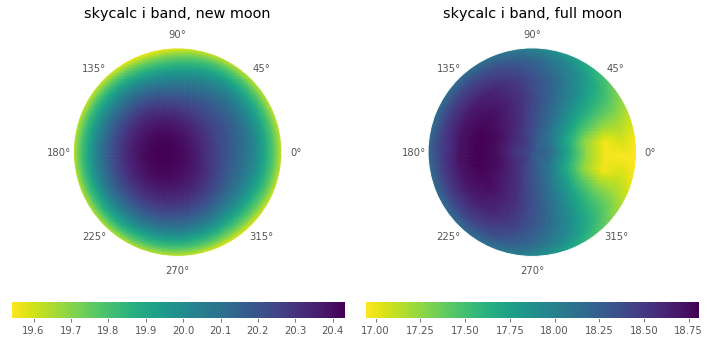

In [10]:
fig = plt.figure(figsize=(10, 5))
zernexam.map_sky(fig, 1, 2, 1, sky.loc[new_moon_mjd], 'sky', 'skycalc i band, new moon', radial_column='zd', cmap='viridis_r', s=15)
zernexam.map_sky(fig, 1, 2, 2, sky.loc[full_moon_mjd], 'sky', 'skycalc i band, full moon', radial_column='zd', cmap='viridis_r', s=15)
plt.tight_layout()

In [11]:
fig.savefig('healpix_map.png')

## Zernike basis functions

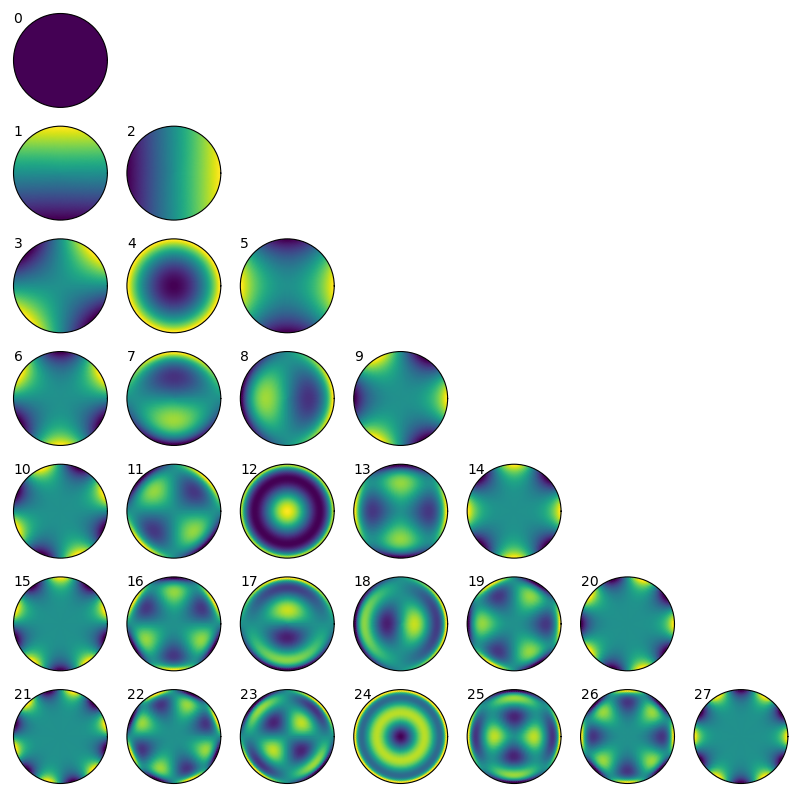

In [432]:
def plot_zernike_basis(zern_order):
    zsky = lsst.sims.skybrightness_pre.zernike.ZernikeSky(order=zern_order, max_zd=70.5)
    zero_coeffs = pd.DataFrame({n:float(0) for n in np.arange(np.sum(np.arange(zsky.order) + 1))}, index=[60000])
    zero_coeffs.index.name = 'mjd'

    with plt.style.context('default'):
        fig = plt.figure(figsize=(10, 10))
        sphere_npix = healpy.nside2npix(zsky.nside)
        sphere_ipix = np.arange(sphere_npix)
        az, alt = healpy.pix2ang(zsky.nside, sphere_ipix, lonlat=True)
        phi, rho = zsky._calc_phi(az), zsky._calc_rho(alt)
        good = rho<1
        alt, az, phi, rho = alt[good], az[good], phi[good], rho[good]

        n_terms = np.sum(np.arange(zsky.order) + 1)
        axes = []
        for j in np.arange(n_terms):
            n = np.ceil((-3 + np.sqrt(9 + 8 * j)) / 2).astype(int)
            mprime = 2 * j - n * (n + 2)
            m = np.abs(mprime)

            coeffs = zero_coeffs.copy()
            coeffs.loc[coeffs.index[0], j] = 1.0
            zsky._coeffs = coeffs

            sky = zsky.compute_sky(alt, az, mjd=60000)

            ax = fig.add_subplot(zsky.order, zsky.order, n*zsky.order+int((n+mprime)/2)+1, projection='polar')
            p = ax.scatter(phi, rho, c=sky, s=1)
            #ax.set_title(f"{j} = {n}, {mprime}")
            ax.annotate(f'{j}', (0, 0.9), xycoords='axes fraction')
            ax.set_ylim([0, 1])
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_xticks([])
            ax.set_yticks([])
            axes.append(ax)
            
    return fig, axes

fig, axes = plot_zernike_basis(7)

In [13]:
fig.savefig('basis7.png')

## Residual maps

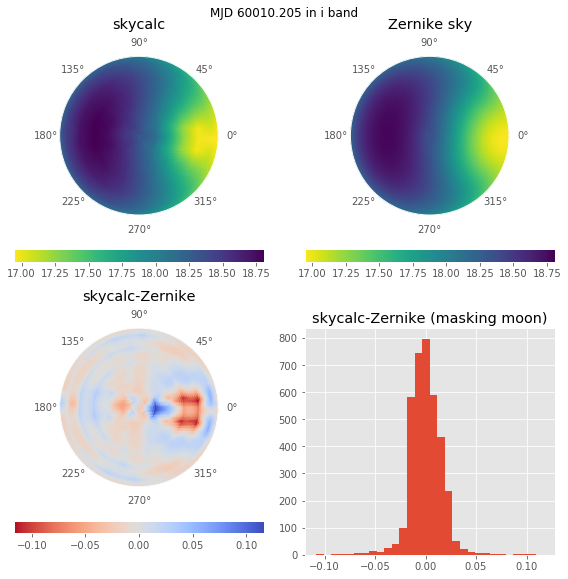

In [14]:
fig, axes = zernexam.resid_map(sky.loc[full_moon_mjd].copy(), full_moon_mjd, 'i')
plt.tight_layout()

In [15]:
fig.savefig('resid_full.png')

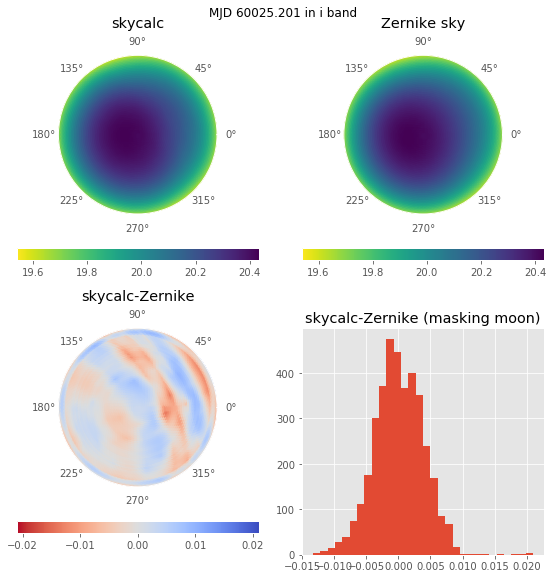

In [16]:
fig, axes = zernexam.resid_map(sky.loc[new_moon_mjd].copy(), new_moon_mjd, 'i')

In [17]:
fig.savefig('resid_new.png')

Find the MJD with the worst residual, and examine:

In [18]:
good_sky = sky.query('moon_sep>15')
max_abs_resid_idx = np.abs(good_sky.resid).argmax()

In [19]:
good_sky.iloc[max_abs_resid_idx].resid

-0.26174954086241087

In [20]:
worst_mjd = good_sky.iloc[max_abs_resid_idx].mjd

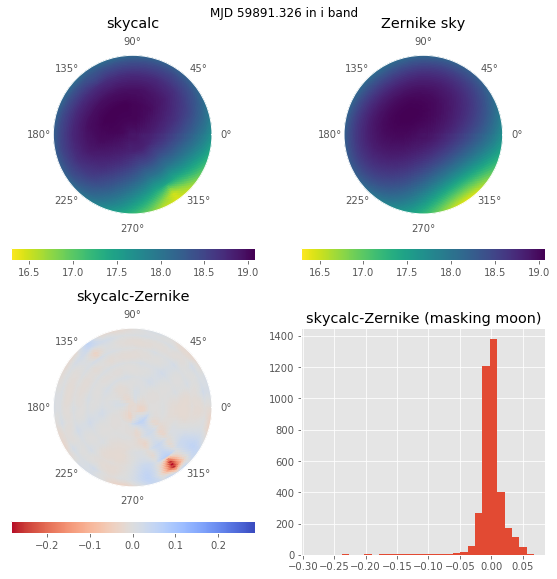

In [21]:
fig, axes = zernexam.resid_map(sky.loc[worst_mjd].copy(), worst_mjd, 'i')

In [22]:
fig.savefig('resid_worst.png')

In [23]:
sky.loc[worst_mjd, ['moon_alt', 'moon_az']].iloc[0]

moon_alt     20.596898
moon_az     305.169207
Name: (20.74237995448713, 0.0), dtype: float64

In [24]:
good_dark_sky = sky.query('moon_sep>15 and moon_alt<-8')
max_abs_resid_idx = np.abs(good_dark_sky.resid).argmax()
worst_dark_mjd = good_dark_sky.iloc[max_abs_resid_idx].mjd

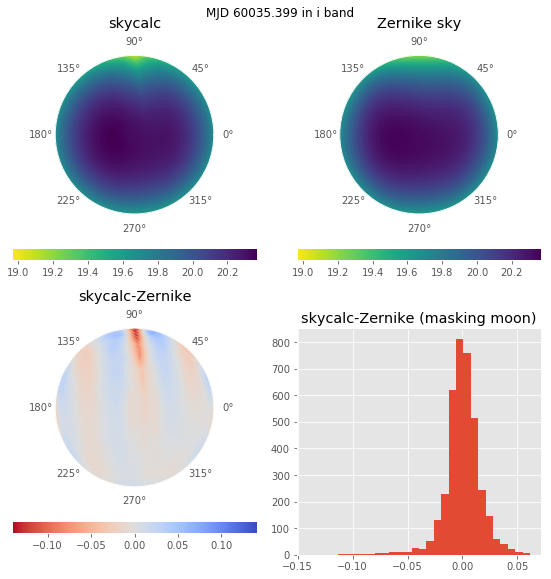

In [25]:
fig, axes = zernexam.resid_map(sky.loc[worst_dark_mjd].copy(), worst_dark_mjd, 'i')

In [26]:
fig.savefig('resid_worst_dark.png')

In [67]:
def sun_coords(mjd, telescope=lsst.sims.utils.Site("LSST")):
    gmst_rad = palpy.gmst(mjd)
    lst_rad = gmst_rad + telescope.longitude_rad
    ra_rad, decl_rad, _ = palpy.rdplan(mjd, 0, telescope.longitude_rad, telescope.latitude_rad)
    ha_rad = lst_rad - ra_rad
    az_rad, alt_rad = palpy.de2h(ha_rad, decl_rad, telescope.latitude_rad)
    az_deg, alt_deg = np.degrees(az_rad), np.degrees(alt_rad)
    return az_deg, alt_deg

sun_coords(worst_dark_mjd)

(95.25086885404023, -17.79373514000063)

In [80]:
Time(worst_dark_mjd, format='mjd', location=EarthLocation.of_site('Cerro Pachon')).iso

'2023-04-01 09:34:59.983'

### Moon near zenith

In [43]:
moon_zenith_mjd = sky.mjd.iloc[sky.moon_alt.argmax()]

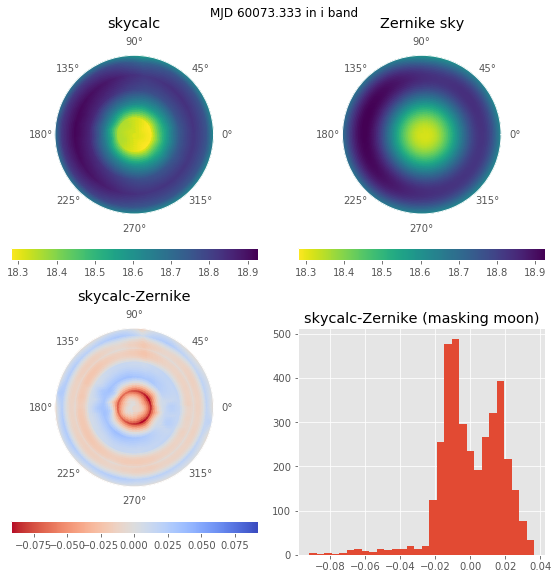

In [44]:
fig, axes = zernexam.resid_map(sky.loc[moon_zenith_mjd].copy(), moon_zenith_mjd, 'i')

In [45]:
fig.savefig('resid_zenith_moon.png')

## Historgrams of residuals with parameters

Text(0.5, 1.0, 'i band, 59823 < MJD < 60191')

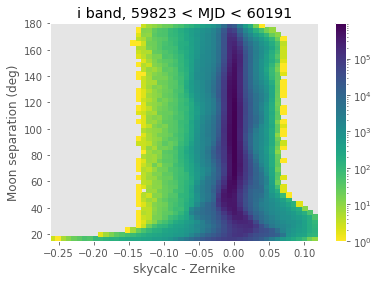

In [27]:
moon_sep_hist = zernexam.resid_2dhist(good_sky, 'moon_sep')
moon_sep_hist.ax.set_xlabel("skycalc - Zernike")
moon_sep_hist.ax.set_ylabel("Moon separation (deg)")
moon_sep_hist.ax.set_title("i band, 59823 < MJD < 60191")

In [28]:
moon_sep_hist.fig.savefig('moon_sep_hist.png')

Text(0.5, 1.0, 'i band, 59823 < MJD < 60191')

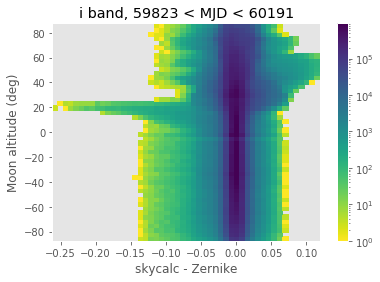

In [29]:
moon_alt_hist = zernexam.resid_2dhist(good_sky, 'moon_alt')
moon_alt_hist.ax.set_xlabel("skycalc - Zernike")
moon_alt_hist.ax.set_ylabel("Moon altitude (deg)")
moon_alt_hist.ax.set_title("i band, 59823 < MJD < 60191")

In [30]:
moon_alt_hist.fig.savefig('moon_alt_hist.png')

Text(0.5, 1.0, 'i band, 59823 < MJD < 60191, with moon')

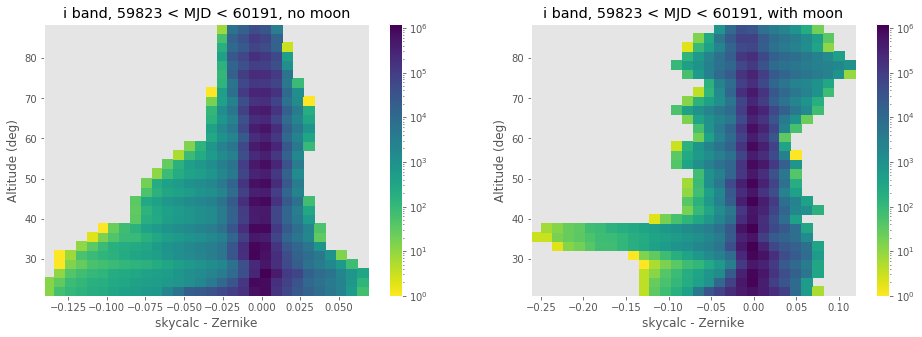

In [138]:
alt_hists = zernexam.resid_2dhist2(good_sky, 'alt', bins=30)
for alt_hist in alt_hists:
    alt_hist.ax.set_xlabel("skycalc - Zernike")
    alt_hist.ax.set_ylabel("Altitude (deg)")
alt_hists[0].ax.set_title("i band, 59823 < MJD < 60191, no moon")
alt_hists[1].ax.set_title("i band, 59823 < MJD < 60191, with moon")

In [136]:
alt_hists[0].fig.savefig('alt_hist.png')

What airmass corresponds to the poorly-performing altitudes?

In [60]:
bad_alt = np.nanmax(good_sky.query('resid < -0.15').alt)

def compute_airmass(alt, a=470.0):
    mu = np.cos(np.radians(90-alt))
    x = np.sqrt(a*a*mu*mu + 2*a + 1) - a*mu
    return x

bad_alt, compute_airmass(bad_alt)

(38.68218745348944, 1.5973590537081463)

Checking if the poor dark sky residuals come from Zodiacal light:

In [122]:
%%time
def ecl(sky):
    lon_rad, lat_rad = palpy.eqeclVector(np.radians(sky.ra.values), np.radians(sky.decl.values), sky.mjd.values[0])
    ecl_coords = pd.DataFrame({'ecl_lon': np.degrees(lon_rad),
                               'ecl_lat': np.degrees(lat_rad),
                               'resid': sky.resid,
                               'alt': sky.alt,
                               'az': sky.az}).set_index(['alt', 'az'])
    return ecl_coords

good_dark_ecl = good_dark_sky.groupby(level='mjd').apply(ecl)

CPU times: user 38.5 s, sys: 7.65 s, total: 46.1 s
Wall time: 46.2 s


Text(0.5, 1.0, 'i band, dark, 59823 < MJD < 60191')

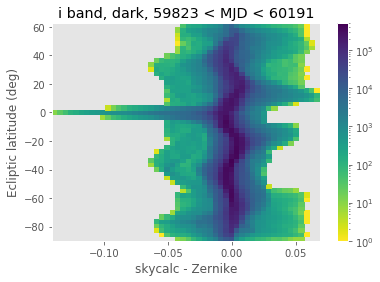

In [131]:
dark_ecl_lat_hist = zernexam.resid_2dhist(good_dark_ecl, 'ecl_lat')
dark_ecl_lat_hist.ax.set_xlabel("skycalc - Zernike")
dark_ecl_lat_hist.ax.set_ylabel("Ecliptic latitude (deg)")
dark_ecl_lat_hist.ax.set_title("i band, dark, 59823 < MJD < 60191")

In [137]:
dark_ecl_lat_hist.fig.savefig('dark_ecl_lat_hist.png')

## Full residuals

In [33]:
resid_files = {'6th order': 'resid_z705_59823_60191.h5',
               '7th order': 'resid_o7_z705_59823_60191.h5',
               '12th order': 'resid_o12_59823_60191.h5'}
bands = 'ugrizy'
orders = ('6th order', '7th order', '12th order')

2020-11-13 18:10:32,879 Loading 6th order, u band
2020-11-13 18:13:32,239 Building histogram
2020-11-13 18:13:41,443 Loading 7th order, u band
2020-11-13 18:16:42,361 Building histogram
2020-11-13 18:16:51,944 Loading 12th order, u band
2020-11-13 18:19:57,855 Building histogram
2020-11-13 18:20:07,564 Loading 6th order, g band
2020-11-13 18:23:22,084 Building histogram
2020-11-13 18:23:31,801 Loading 7th order, g band
2020-11-13 18:26:27,067 Building histogram
2020-11-13 18:26:36,235 Loading 12th order, g band
2020-11-13 18:29:31,651 Building histogram
2020-11-13 18:29:41,153 Loading 6th order, r band
2020-11-13 18:32:34,816 Building histogram
2020-11-13 18:32:43,996 Loading 7th order, r band
2020-11-13 18:35:37,636 Building histogram
2020-11-13 18:35:47,120 Loading 12th order, r band
2020-11-13 18:38:41,448 Building histogram
2020-11-13 18:38:50,811 Loading 6th order, i band
2020-11-13 18:41:49,245 Building histogram
2020-11-13 18:41:57,917 Loading 7th order, i band
2020-11-13 18:44:

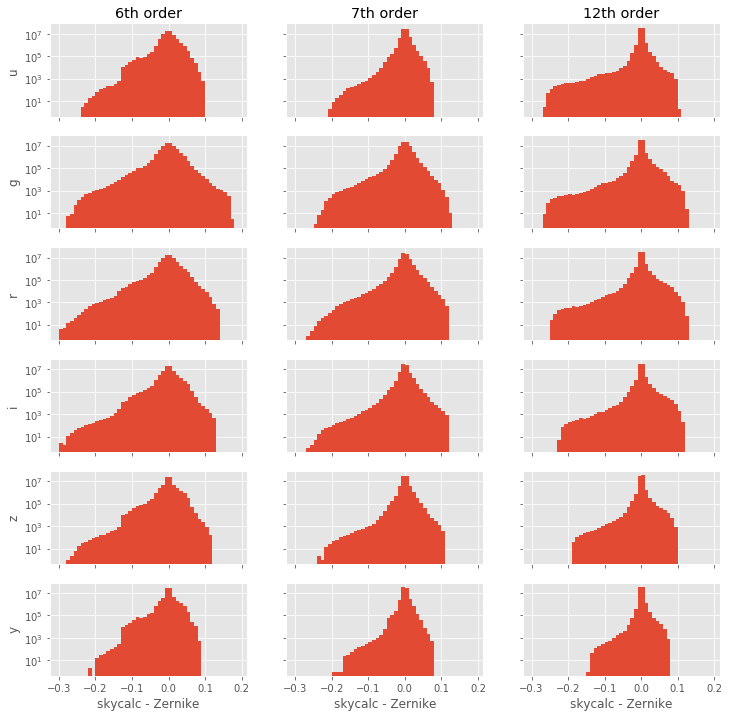

In [36]:
def plot_all_resid_hists(resid_files, bands, orders, in_sky=None):
    fig, axes = plt.subplots(len(bands), len(orders), figsize=(12, 12), sharex=True, sharey=True)
    for row, band in enumerate(bands):
        for col, order in enumerate(orders):
            logger.info(f"Loading {order}, {band} band")
            if in_sky is None:
                sky = pd.read_hdf(resid_files[order], band).query('moon_sep>15')
            else:
                sky = in_sky
            ax = axes[row, col] if isinstance(axes, np.ndarray) else axes
            logger.info("Building histogram")
            ax.hist(sky.resid, bins=np.arange(-0.3, 0.2, 0.01), log=True)
            if row==0:
                ax.set_title(order)
            if col==0:
                ax.set_ylabel(band)
            if row==len(bands)-1:
                ax.set_xlabel("skycalc - Zernike")
            if in_sky is None:
                del sky
    return fig, axes
            
fig, axes = plot_all_resid_hists(resid_files, bands, orders)

In [37]:
fig.savefig('residual_hists.png')

## Zernike term interpolation

/cvmfs/sw.lsst.eu/linux-x86_64/lsst_sims/sims_w_2020_43/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


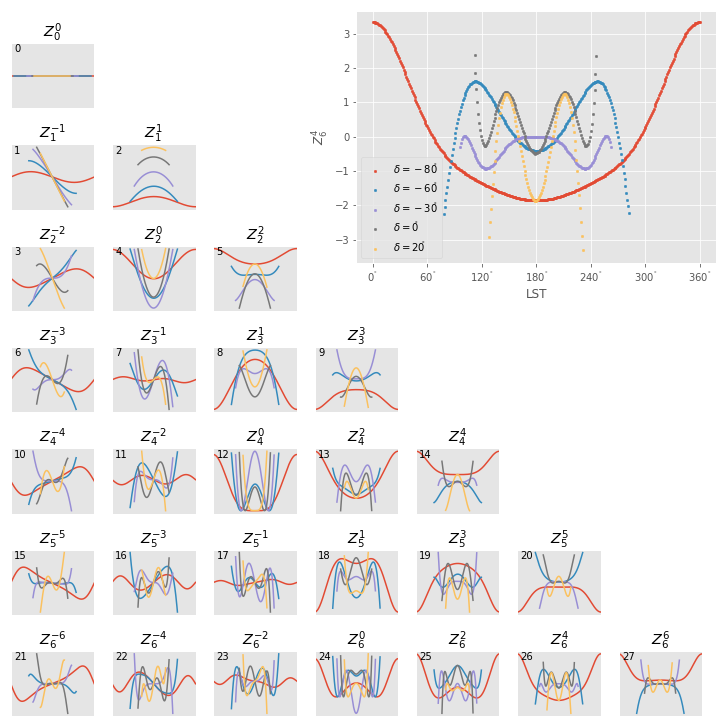

In [563]:
def plot_zernike_by_lst(zern_order, projection=None):
    zsky = lsst.sims.skybrightness_pre.zernike.ZernikeSky(order=zern_order, max_zd=70.5)
    z = zsky.healpix_z
    sphere_npix = healpy.nside2npix(zsky.nside)
    
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(10, 10))
        big_ax = fig.add_axes((0.5, 0.65, 0.5, 0.35), projection=projection)

        n_terms = np.sum(np.arange(zsky.order) + 1)
        axes = []
        for j in np.arange(n_terms):
            n = np.ceil((-3 + np.sqrt(9 + 8 * j)) / 2).astype(int)
            mprime = 2 * j - n * (n + 2)
            m = np.abs(mprime)

            ax = fig.add_subplot(zsky.order, zsky.order, n*zsky.order+int((n+mprime)/2)+1, projection=projection)
            
            for decl in (-80, -60, -30, 0, 20):
                hpix = healpy.ang2pix(zsky.nside, 109, decl, lonlat=True)
                lst = np.arange(zsky.healpix_z.shape[0])
                if projection == 'polar':
                    lst = np.radians(lst)
                    
                pix_z = pd.DataFrame(
                        {'lst': lst, 
                         'z': zsky.healpix_z[:, hpix, j]})

                p = pix_z.plot('lst', 'z', ax=ax, legend=False)
                
                if j == 26:
                    big_ax.set_ylabel(f'$Z^{{{mprime}}}_{n}$')
                    big_p = big_ax.scatter(pix_z['lst'], pix_z['z'], s=6, label=rf'$\delta={decl}^{{\ocirc}}$')
                    big_ax.legend()
                    #big_p = pix_z.plot('lst', 'z', ax=big_ax,
                    #                   label=rf'$\delta={decl}^{{\ocirc}}$')
            
            ax.annotate(f'{j}', (0.04, 0.86), xycoords='axes fraction')
            if projection != "polar":
                ax.set_xlim(0, 360)
                
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.set_xticks([])
            #ax.set_xticklabels([])
            ax.set_yticks([])
            #ax.set_yticklabels([])
            ax.set_title(f'$Z^{{{mprime}}}_{n}$')
            axes.append(ax)
            
    big_ax.set_xlabel('LST')
    big_xticks = np.arange(0, 361, 60)
    big_ax.set_xticks(big_xticks)
    big_ax.set_xticklabels(f'{x} ' + r'$^{\ocirc}$' for x in big_xticks)
        
            
    plt.tight_layout()
    return fig, axes

fig, axes = plot_zernike_by_lst(7)

In [564]:
fig.savefig('Z_vs_LST.png')

# Zernike coefficient interpolation

In [565]:
zsky = lsst.sims.skybrightness_pre.zernike.ZernikeSky(order=7, max_zd=70.5)
zsky.load_coeffs('/data/des70.a/data/neilsen/ehn_lsst_scratch/sky_brightness/bulkzern_o7_z705.h5', 'i')

In [566]:
def plot_coeffs_by_lst(mjd_min, mjd_max):
    zsky = lsst.sims.skybrightness_pre.zernike.ZernikeSky(order=7, max_zd=70.5) 
    
    with plt.style.context('ggplot'):
        fig = plt.figure(figsize=(12, 12))

        axes = {}
        for band in 'ugrizy':
            color = BAND_COLOR[band]
            alpha = 1 if band=='i' else 0.25
            zsky.load_coeffs('/data/des70.a/data/neilsen/ehn_lsst_scratch/sky_brightness/bulkzern_o7_z705.h5', band)
            n_terms = np.sum(np.arange(zsky.order) + 1)
            night_coeffs = zsky._coeffs.loc[mjd_min:mjd_max].reset_index(drop=False)
            for j in np.arange(n_terms):
                n = np.ceil((-3 + np.sqrt(9 + 8 * j)) / 2).astype(int)
                mprime = 2 * j - n * (n + 2)
                m = np.abs(mprime)

                zscale = np.nanmax(np.abs(zsky.healpix_z[:, :, j]))
                
                try:
                    ax = axes[j]
                except KeyError:
                    ax = fig.add_subplot(zsky.order, zsky.order, n*zsky.order+int((n+mprime)/2)+1)
                    axes[j] = ax
                    
                if j==0:
                    ax.scatter(night_coeffs.mjd, night_coeffs[j], s=2, alpha=alpha, c=color)
                else:
                    ax.scatter(night_coeffs.mjd, night_coeffs[j]*zscale, s=2, alpha=alpha, c=color)
                    yrange = 2.4 if n<3 else 1.6 if n<4 else 0.4
                    ymin, ymax = -1*yrange/2, yrange/2
                    ax.set_ylim(ymin, ymax)
                    yticks = np.arange(ymin, ymax, yrange/8)
                    ax.set_yticks(yticks)
                    if mprime != -1*n:
                        ax.set_yticklabels('' for x in yticks)

                ax.annotate(f'{j}', (0.04, 0.86), xycoords='axes fraction')

                ax.set_ylabel('')
                ax.set_xlabel('')
                ax.set_xticks([])
                ax.set_title(f'$Z^{{{mprime}}}_{n}$')

    plt.tight_layout()
    return fig, axes

#mjd_start, mjd_end = sky.loc[60103.8:60104.6].query('sun_alt<-12').mjd.describe()[['min', 'max']]
#fig, axes = plot_coeffs_by_lst(mjd_start, mjd_end)

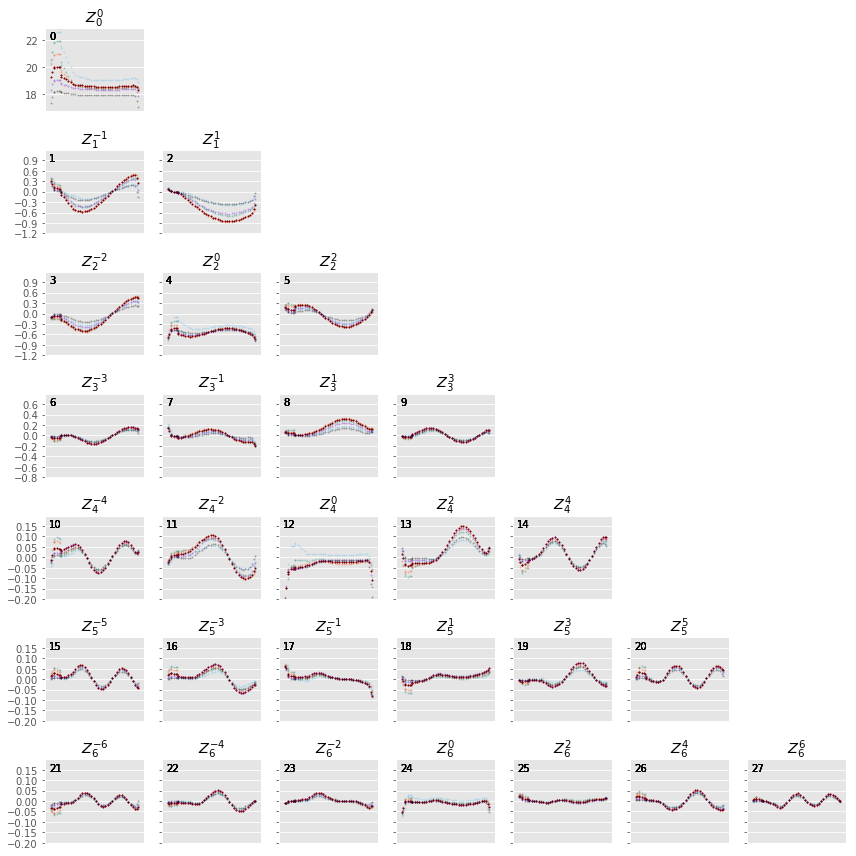

In [567]:
mjd_start, mjd_end = sky.loc[worst_mjd-0.2:worst_mjd+0.7].query('sun_alt<-12').mjd.describe()[['min', 'max']]
fig, axes = plot_coeffs_by_lst(mjd_start, mjd_end)

In [568]:
fig.savefig('worst_coeff_vs_time.png')